In [2]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt

In [3]:
from pprint import pprint
r = requests.get('http://172.18.198.27:9200/es_user_table')
pprint(r.json())

{'es_user_table': {'aliases': {},
                   'mappings': {'user': {'dynamic_templates': [{'id': {'mapping': {'type': 'long'},
                                                                       'match': 'id'}},
                                                               {'updated': {'mapping': {'type': 'long'},
                                                                            'match': 'updated'}},
                                                               {'created': {'mapping': {'type': 'long'},
                                                                            'match': 'created'}},
                                                               {'content': {'mapping': {'analyzer': 'ik_smart',
                                                                                        'index': 'true',
                                                                                        'type': 'text'},
                                                  

In [4]:
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

def to_df(res):                                                                       #时间调整
    test_df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    test_df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(test_df.columns))
    #test_df['日期'] = test_df['日期'].apply(to_date)
    #test_df['日期'] = pd.to_datetime(test_df['日期'])
    #test_df['current_vip_created']= test_df['current_vip_created'].apply(to_date)
    #test_df['current_vip_created']= pd.to_datetime(test_df['current_vip_created'])
    test_df['购买列表']= test_df['购买列表'].apply(to_date)
    #test_df['购买列表']= pd.to_datetime(test_df['购买列表'])
    return test_df

def get_result(dsl,index,doc_type):
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index=index, doc_type=doc_type, body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
    df = to_df(res)
    return df

In [5]:
dsl1 = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [#{'日期': {'date_histogram': {'field': 'first_paytime',
                                                   #                           'interval': '1d',
                                                   #                           'time_zone': '+00:00'}}},
                                                   {'id': {'terms': {'field': 'id'}}},
                                                   #{'current_vip_created': {'date_histogram': {'field': 'current_vip_created',
                                                   #                                             'interval': '1d',
                                                   #                                             'time_zone': '+00:00'}}},
                                                   {'购买列表': {'date_histogram': {'field': 'user_paytime_list',
                                                                                             'interval': '1d',
                                                                                             'time_zone': '+00:00'}}},
                                                   #{'第一次会员由来': {'terms': {'field': 'first_vip_plan_id'}}},
                                                   #{'最后一次会员': {'terms': {'field': 'last_vip_plan_id'}}},
                                                  ]}}},
 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': '2019-03-28',
                                                              'lte': '2019-06-08',
                                                              'time_zone': '+00:00'}}}]}}}

In [8]:
df1 = get_result(dsl1,'es_user_table','user')
df1.head()
df1.to_csv('购买列表.csv')

In [9]:
#得到最后一次购买时间购买总次数
df1 = pd.read_csv('购买列表.csv')
def get_first_date(s):                                                    
    data= {}
    data['最后购买'] = s['购买列表'].max()
    return pd.Series(data)
dts = df1.groupby('id').apply(get_first_date).reset_index()
dts.head()

,id,最后购买
0,15420,2019-05-15
1,18178,2019-04-17
2,20089,2019-05-02
3,20147,2019-04-12
4,20156,2019-05-26


In [10]:
dts['最后购买']= pd.to_datetime(dts['最后购买'])
dts.iloc[0]['最后购买']

Timestamp('2019-05-15 00:00:00')

In [11]:
today = datetime.date.today()
pd.to_datetime(today)

Timestamp('2019-06-09 00:00:00')

In [12]:
delta =pd.to_datetime(today)-dts.iloc[0]['最后购买']
delta.days

25

In [13]:
day_count = []
bar = progressbar
for i in bar.progressbar(range(len(dts))):
    delta =pd.to_datetime(today)-dts.iloc[i]['最后购买']
    day_count.append(delta.days)

100% (120291 of 120291) |################| Elapsed Time: 0:01:01 Time:  0:01:01


In [24]:
dts['天数'] = day_count
dts.head()
dts.to_csv('购买天数列表.csv')

In [15]:
len(dts)

120291

In [16]:
number = pd.Series(day_count).quantile(0.5)
number

26.0

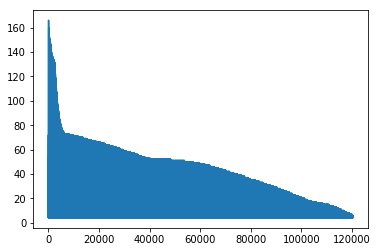

In [17]:
plt.plot(dts['天数'])

In [18]:
active, nonactive, status = [],[],[]
bar = progressbar
for i in bar.progressbar(range(len(dts))):
    if dts.iloc[i]['天数']>30:
        status.append('静默')
        nonactive.append(dts.iloc[i]['id'])
    else:
        status.append('活跃')
        active.append(dts.iloc[i]['id'])

100% (120291 of 120291) |################| Elapsed Time: 0:01:00 Time:  0:01:00


In [25]:
dts['状态'] = status
dts.head()
dts.to_csv('购买状态列表1.csv')

In [20]:
len(dts)

120291

In [21]:
dsl_list = {
                'query': {'bool': {'must': [
                                            {'terms': {'order_type': ['vip_scan','scan']}},
                                            {'terms': {'user_id': dts['id'].tolist()}},
                                            #{'query_string': {'query': 'skutotal_price != 0'}},
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{"用户ID": {"terms": {"field": 'user_id'}}},
                               #{"日期": {"date_histogram": {"field": "paytime", "interval": "1d"}}},
                                {"单价": {"terms": {"field": 'skutotal_price'}}}
                               # {"门店": {"terms": {"field": 'shop_id'}}}
                                
                                ]
                        }
                    }
                }
            }
es_list = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_list = es_list.search(index='es_order_table', doc_type='order', body=dsl_list,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_list = json_normalize(res_list['aggregations']['my_buckets']['buckets'])
df_list.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_list.columns))

In [22]:
def number_and_total(s):
    data = {}
    data['number_list'] = len(s['单价'])
    data['total_list'] = s['单价'].sum()
    return  pd.Series(data)

In [26]:
df_abc =  df_list.groupby('用户ID').apply(number_and_total)
df_abc.head()
df_abc.to_csv('购买订单列表.csv')

In [27]:
len(df_abc)

92052

In [28]:
df_abc.index[0]

15420

In [29]:
df_abc = pd.read_csv('购买订单列表.csv')
number_id,total_id=[],[]
for i in bar.progressbar(range(len(dts))):
    if dts.iloc[i]['id'] in df_abc.index:
        number_id.append(df_abc.loc[dts.iloc[i]['id']]['number_list'])
        total_id.append(df_abc.loc[dts.iloc[i]['id']]['total_list'])
    else:
        number_id.append(0)
        total_id.append(0)

100% (120291 of 120291) |################| Elapsed Time: 0:02:10 Time:  0:02:10


In [30]:
dts['购买数']=number_id
dts['购买金额']=total_id

In [31]:
dts.head()

,id,最后购买,天数,状态,购买数,购买金额
0,15420,2019-05-15,25,活跃,5.0,95.680000
1,18178,2019-04-17,53,静默,11.0,315.639999
2,20089,2019-05-02,38,静默,6.0,86.500000
3,20147,2019-04-12,58,静默,1.0,15.000000
4,20156,2019-05-26,14,活跃,10.0,94.190000


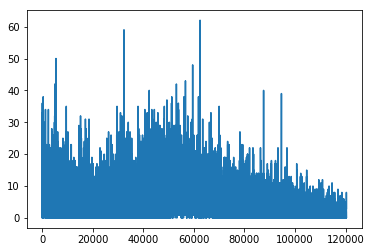

In [32]:
plt.plot(dts['购买数'])

In [33]:
number_med = pd.Series(dts['购买数']).quantile(0.8)
number_med

3.0

In [34]:
buy_a_lot, buy_a_little, status_id = [],[],[]
bar = progressbar
for i in bar.progressbar(range(len(dts))):
    if dts.iloc[i]['购买数']>3:
        status_id.append('剁手')
        buy_a_lot.append(dts.iloc[i]['id'])
    else:
        status_id.append('老实')
        buy_a_little.append(dts.iloc[i]['id'])

100% (120291 of 120291) |################| Elapsed Time: 0:01:11 Time:  0:01:11


In [35]:
dts['消费习惯'] = status_id
dts.to_csv('购买状态列表2.csv')

In [37]:
dts.head()

,id,最后购买,天数,状态,购买数,购买金额,消费习惯
0,15420,2019-05-15,25,活跃,5.0,95.680000,剁手
1,18178,2019-04-17,53,静默,11.0,315.639999,剁手
2,20089,2019-05-02,38,静默,6.0,86.500000,剁手
3,20147,2019-04-12,58,静默,1.0,15.000000,老实
4,20156,2019-05-26,14,活跃,10.0,94.190000,剁手


In [36]:
dts['购买金额'].max()

11399.10000000149

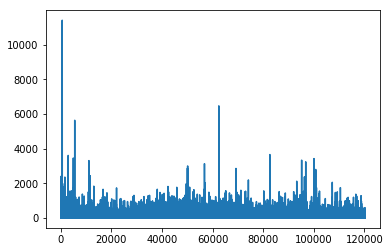

In [32]:
plt.plot(dts['购买金额'])

In [33]:
number = pd.Series(total_id).quantile(0.5)
number

24.170000076293945

In [47]:
the_rich, the_poor, status_money = [],[],[]
bar = progressbar
for i in bar.progressbar(range(len(dts))):
    if dts.iloc[i]['购买金额']>25:
        status_money.append('有钱人')
        the_rich.append(dts.iloc[i]['id'])
    else:
        status_money.append('一般人')
        the_poor.append(dts.iloc[i]['id'])

100% (120291 of 120291) |################| Elapsed Time: 0:01:00 Time:  0:01:00


In [48]:
dts['花销'] = status_money
dts.head()
dts.to_csv('购买状态列表3.csv')

In [87]:
dts = pd.read_csv('购买状态列表3.csv')

In [88]:
dts.head()

,Unnamed: 0,Unnamed: 0.1,id,最后购买,天数,状态,购买数,购买金额,消费习惯,花销
0,0,0,15420,2019-05-15,25,活跃,5.0,95.680000,剁手,有钱人
1,1,1,18178,2019-04-17,53,静默,11.0,315.639999,剁手,有钱人
2,2,2,20089,2019-05-02,38,静默,6.0,86.500000,剁手,有钱人
3,3,3,20147,2019-04-12,58,静默,1.0,15.000000,老实,一般人
4,4,4,20156,2019-05-26,14,活跃,10.0,94.190000,剁手,有钱人


In [97]:
sns.set()
x=dts['购买数'][0:8000]
x.head()

0     5.0
1    11.0
2     6.0
3     1.0
4    10.0
Name: 购买数, dtype: float64

In [74]:
xyz = sns.load_dataset(x)
ax = plot(x="购买数", y="", data=xyz)

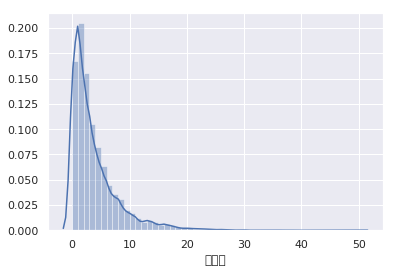

In [98]:
sns.distplot(x)